In [ ]:
!pip install langchain_chroma pytube youtube-search youtube-transcript-api nest_asyncio wolframalpha 

### Asynchronous setup for leveraging the WolframAlpha API

In [1]:
import asyncio
asyncio.set_event_loop_policy(asyncio.DefaultEventLoopPolicy())

import nest_asyncio
nest_asyncio.apply()

In [2]:
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper

wolfram = WolframAlphaAPIWrapper()

### State

In [3]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    focus: Literal["web", "academic", "video", "math"]

### Tools

In [4]:
import re

from langgraph.prebuilt import ToolNode

from langchain_core.tools import tool
from langchain_community.tools import YouTubeSearchTool
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper


web_tool = TavilySearchResults(max_results=2)

@tool
def academic_tool(query: str):
    """academic paper search tool"""
    arxiv = ArxivAPIWrapper()
    docs = arxiv.run(query)
    return docs

@tool
def math_tool(query: str):
    """math tool"""
    wolfram = WolframAlphaAPIWrapper()
    result = wolfram.run(query)
    return result

In [10]:
academic_tool.run("AI Agent")

'Published: 2024-03-22\nTitle: CACA Agent: Capability Collaboration based AI Agent\nAuthors: Peng Xu, Haoran Wang, Chuang Wang, Xu Liu\nSummary: As AI Agents based on Large Language Models (LLMs) have shown potential in\npractical applications across various fields, how to quickly deploy an AI agent\nand how to conveniently expand the application scenario of AI agents has become\na challenge. Previous studies mainly focused on implementing all the reasoning\ncapabilities of AI agents within a single LLM, which often makes the model more\ncomplex and also reduces the extensibility of AI agent functionality. In this\npaper, we propose CACA Agent (Capability Collaboration based AI Agent), using\nan open architecture inspired by service computing. CACA Agent integrates a set\nof collaborative capabilities to implement AI Agents, not only reducing the\ndependence on a single LLM, but also enhancing the extensibility of both the\nplanning abilities and the tools available to AI agents. Utili

In [11]:
math_tool.run("123*123^2")

'Assumption: 123×123^2 \nAnswer: 1860867'

In [5]:
# Video Search
import ast

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import YoutubeLoader

youtube_search_tool = YouTubeSearchTool()

@tool
def video_tool(query: str) -> str:
    """
    Retriever tool for the transcript of a YouTube video.
    If user want to find some information, this tool is good to gather youtube video information.
    query should be given in string format.
    """

    urls = youtube_search_tool.run(query)
    urls = ast.literal_eval(urls)

    docs = []
    for url in urls:
        loader = YoutubeLoader.from_youtube_url(
            url,
            add_video_info=True,
            language=["en", "ko"]
        )
        scripts = loader.load()
        script_content = scripts[0].page_content
        title = scripts[0].metadata['title']
        author = scripts[0].metadata['author']
        doc = Document(page_content=script_content, metadata={"source": url, "title": title, "author": author})
        docs.append(doc)

    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ".", ",", " ", ""],
        chunk_size=1000,
        chunk_overlap=0
    )
    texts = text_splitter.split_documents(docs)
    embeddings = OpenAIEmbeddings()
    db = Chroma.from_documents(texts, embeddings)
    retriever = db.as_retriever()
    retrieved_docs = retriever.invoke(query)

    video_results = []
    for doc in retrieved_docs:
        title = doc.metadata.get('title', 'No title available')
        author = doc.metadata.get('author', 'No author available')
        script_content = doc.page_content

        video_info = f"""
        Video Information:
        ------------------
        Title: {title}
        Author: {author}
        Transcript:
        {script_content}
        ------------------
        """
        video_results.append(video_info)

    all_video_results = "\n\n".join(video_results)

    return all_video_results

In [ ]:
video_tool.run("who is teddynote")

### ToolNode

In [9]:
tools = {
    "web": [web_tool],
    "academic": [academic_tool],
    "video": [video_tool],
    "math":[math_tool]
}

tool_nodes = {focus: ToolNode(tools[focus]) for focus in tools}

In [10]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    llm_with_tools = llm.bind_tools(tools[state["focus"]])
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

In [11]:
from langgraph.graph import StateGraph, END

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

for focus, tool_node in tool_nodes.items():
    graph_builder.add_node(f"{focus}_tools", tool_node)

def focus_condition(state):
    if state["messages"][-1].tool_calls:
        return f"{state['focus']}_tools"
    return END  # END 상수 사용

graph_builder.add_conditional_edges(
    "chatbot",
    focus_condition,
    {
        "web_tools": "web_tools",
        "academic_tools": "academic_tools",
        "video_tools": "video_tools",
        "math_tools": "math_tools",
        END: END
    }
)

for focus in tools:
    graph_builder.add_edge(f"{focus}_tools", "chatbot")

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

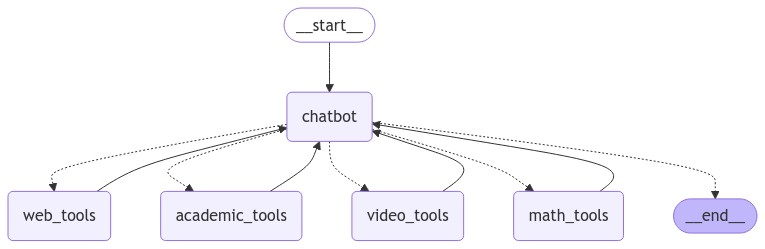

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
s3